In [48]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error

In [83]:
#Read NN and BMS data
n=0;runid=0;function='leaky_ReLU' #tanh, leaky_ReLU
realization=2
sigma=0.2
NPAR=10 #10, 20
steps=50000


#Read NN data
train_size=60
file_model='NN_no_overfit_' + function + '_sigma_' + str(sigma) + '_r_' + str(realization) + '.csv'

#NN_leaky_ReLU_sigma_0.06
#Old naming convention
#----------------------------------------------------------------------------------------------------------------
#noise=True
#if noise==True:
#    file_model='NN_best_model_noise_no_overfit_' + function + '_train_' + str(train_size) + '_NREP_10_data.csv'
    #file_model='NN_model_noise_' + function + '_train_' +str(train_size)+ '_NREP_10_data' + '.csv'
#else:
#    file_model='NN_model_' + function + '_train_' +str(train_size)+ '_NREP_10_data' + '.csv'
model_d='../data/' + file_model
d=pd.read_csv(model_d)
dn=d[d['rep']==n]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)


#Read BMS data
filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
#filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+'_trace_'+str(steps)+'_prior_'+str(NPAR)+'_id_'+str(runid)+'.csv'

#Old naming convention
#--------------------------------------------------------------------------------------------
#if noise==True:
#    filename='BMS_noise_' + function + '_' + str(steps) + '_trace.' + str(n) + '_prior_'  + str(NPAR) + '_id_' + str(runid) + '.csv'
#else:
#    filename='BMS_' + function + '_trace.' + str(n) + '_prior_'  + str(NPAR) + '_id_' + str(runid) + '.csv'
#--------------------------------------------------------------------------------------------
print(filename)
trace=pd.read_csv('../data/MSTraces/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])
display(trace)

BMS_leaky_ReLU_n_0_sigma_0.2_r_2_trace_50000_prior_10.csv


,t,H,expr,parvals,kk1,kk2,kk3
0,0,-3.995046,_a5_,"{'d0': {'_a5_': 0.14830362846504638, '_a0_': 1...",{'d0': 2.682692974699055},-7.990093,0.000000
1,1,-3.995046,_a5_,"{'d0': {'_a5_': 0.14830362846504638, '_a0_': 1...",{'d0': 2.682692974699055},-7.990093,0.000000
2,2,-3.995046,_a5_,"{'d0': {'_a5_': 0.14830362846504638, '_a0_': 1...",{'d0': 2.682692974699055},-7.990093,0.000000
3,3,-3.995046,_a5_,"{'d0': {'_a5_': 0.14830362846504638, '_a0_': 1...",{'d0': 2.682692974699055},-7.990093,0.000000
4,4,-3.995046,_a5_,"{'d0': {'_a5_': 0.14830362846504638, '_a0_': 1...",{'d0': 2.682692974699055},-7.990093,0.000000
...,...,...,...,...,...,...,...
49995,49995,8.074302,exp(((x1 / -(_a6_)) + _a6_)),"{'d0': {'_a6_': -1.637976313938415, '_a0_': 1....",{'d0': 2.007524736256849},-25.385211,20.766908
49996,49996,8.074302,exp(((x1 / -(_a6_)) + _a6_)),"{'d0': {'_a6_': -1.637976313938415, '_a0_': 1....",{'d0': 2.007524736256849},-25.385211,20.766908
49997,49997,8.074302,exp(((x1 / -(_a6_)) + _a6_)),"{'d0': {'_a6_': -1.637976313938415, '_a0_': 1....",{'d0': 2.007524736256849},-25.385211,20.766908
49998,49998,8.074302,exp(((x1 / -(_a6_)) + _a6_)),"{'d0': {'_a6_': -1.637976313938415, '_a0_': 1....",{'d0': 2.007524736256849},-25.385211,20.766908


In [84]:
#Parameters to read models
display(dn)
VARS = ['x1',]
x = dn[[c for c in VARS]].copy()

y=dn.noise

#if noise==True:
#    y=dn.y_noise
#else:
#    y = dn.y

if NPAR==10:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
elif NPAR==20:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

,x1,y,rep,noise,y_noise,ymodel
0,-1.95,0.003403,0.0,-0.188192,-0.184789,-0.039958
1,-1.90,0.003406,0.0,0.060513,0.063919,-0.033990
2,-1.85,0.003409,0.0,0.024851,0.028260,-0.027973
3,-1.80,0.003413,0.0,-0.001240,0.002173,-0.021910
4,-1.75,0.003416,0.0,-0.194319,-0.190903,-0.015804
...,...,...,...,...,...,...
75,1.80,0.533152,0.0,0.046271,0.579423,0.380495
76,1.85,0.544009,0.0,-0.041542,0.502467,0.384064
77,1.90,0.554866,0.0,0.011345,0.566211,0.387566
78,1.95,0.565723,0.0,0.000360,0.566082,0.391003


In [85]:
#Minimum description length
#mdl model
minrow = trace[trace.H == min(trace.H)].iloc[0]
minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=minexpr,
)

t.set_par_values(deepcopy(minparvals))

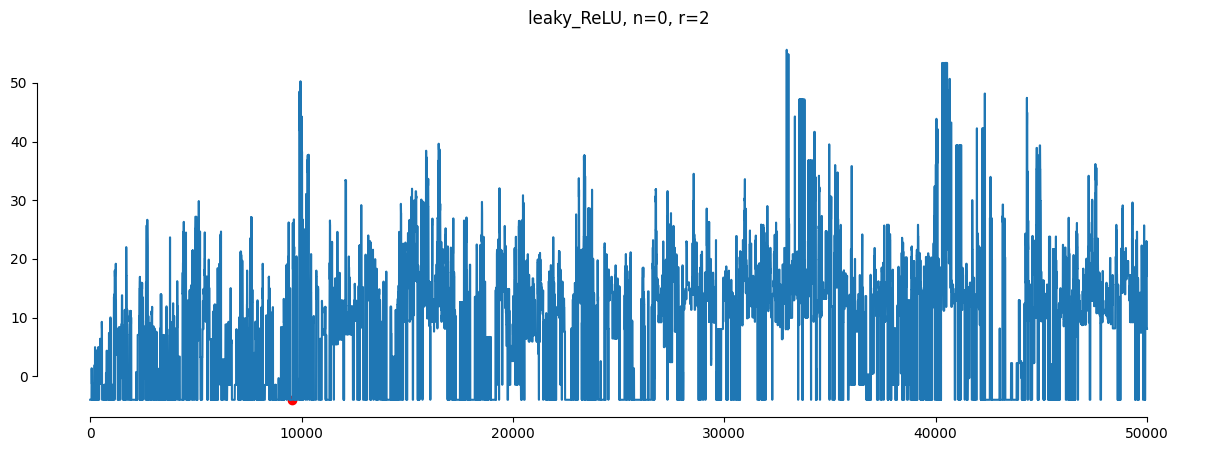

In [86]:
Nini = 00
plt.figure(figsize=(15, 5))

#Define figure size in cm                                                                           
Extensions=['.png']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                           
plt.title(str(function) + ', ' + 'n=' + str(n) +', r=' + str(realization))
plt.plot(trace.t[trace.t > Nini], trace.H[trace.t > Nini])
plt.scatter(minrow['t'], minH,color='r')
#plt.plot(trace.t, trace.H)
sns.despine(trim=True)

Name_figure='Energy_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

#if noise==True:
#    Name_figure='Energy_noise_' + function + '_' + str(n) + '_' + str(runid) + '_par_' + str(NPAR)
#else:
#    Name_figure='Energy_' + function + '_' + str(n) + '_' + str(runid) + '_par_' + str(NPAR)
for ext in Extensions:
        plt.savefig('../results/' + Name_figure + ext,dpi=300)

 
plt.show()

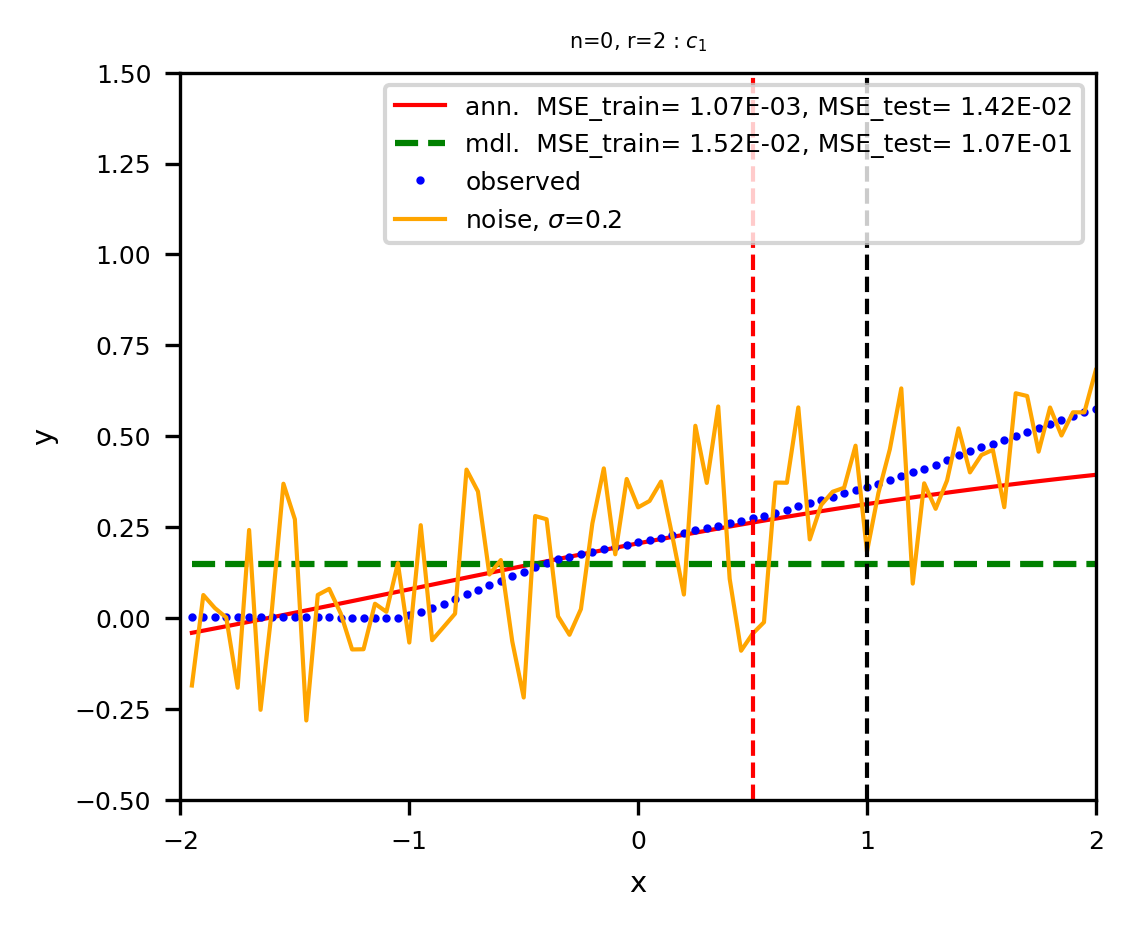

In [87]:
#Plot
train_size_ann=50
validation_border=dn.loc[train_size_ann-1]['x1']
train_border=dn.loc[train_size-1]['x1']

dplot = deepcopy(dn)
dplot['ybms'] = t.predict(x)

#MAE_bms=mean_squared_error(dplot.ybms,dn.y)
#MAE_nn=mean_squared_error(dplot.ymodel,dn.y)

MAE_nn_train=mean_squared_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
MAE_nn_test=mean_squared_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])

MAE_mdl=mean_squared_error(dplot.ybms,dn.y)
MAE_mdl_train=mean_squared_error(dplot.loc[:train_size-1]['ybms'],dn.loc[:train_size-1]['y'])
MAE_mdl_test =mean_squared_error(dplot.loc[train_size-1:]['ybms'],dn.loc[train_size-1:]['y'])

 
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm

Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          


fig=figure(figsize=(width,height), dpi=300)                                                        

plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  MSE_train= %.2E, MSE_test= %.2E' % ( MAE_nn_train, MAE_nn_test)) 
plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label='mdl.  MSE_train= %.2E, MSE_test= %.2E' % ( MAE_mdl_train, MAE_mdl_test)) 
plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed') 
plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange',label='noise, ' + r'$\sigma$=' + str(sigma) ) 
                                                                                

plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

#plt.title('$%s$' % t.latex(),fontsize=size_title)
plt.title('n=%d, r=%d : $%s$' % (n, realization, t.latex()),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

plt.xlim(-2,2);plt.ylim(-0.5,1.5)                                               

Name_figure='Prediction_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)
#if noise==True:
#    Name_figure='Prediction_mdl_noise_' + function + '_' + str(n) + '_' + 'run_' + str(runid) +'_par_' + str(NPAR)
#else:
#    Name_figure='Prediction_mdl_noise_' + function + '_' + str(n) + '_par_' + str(NPAR)
    
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()

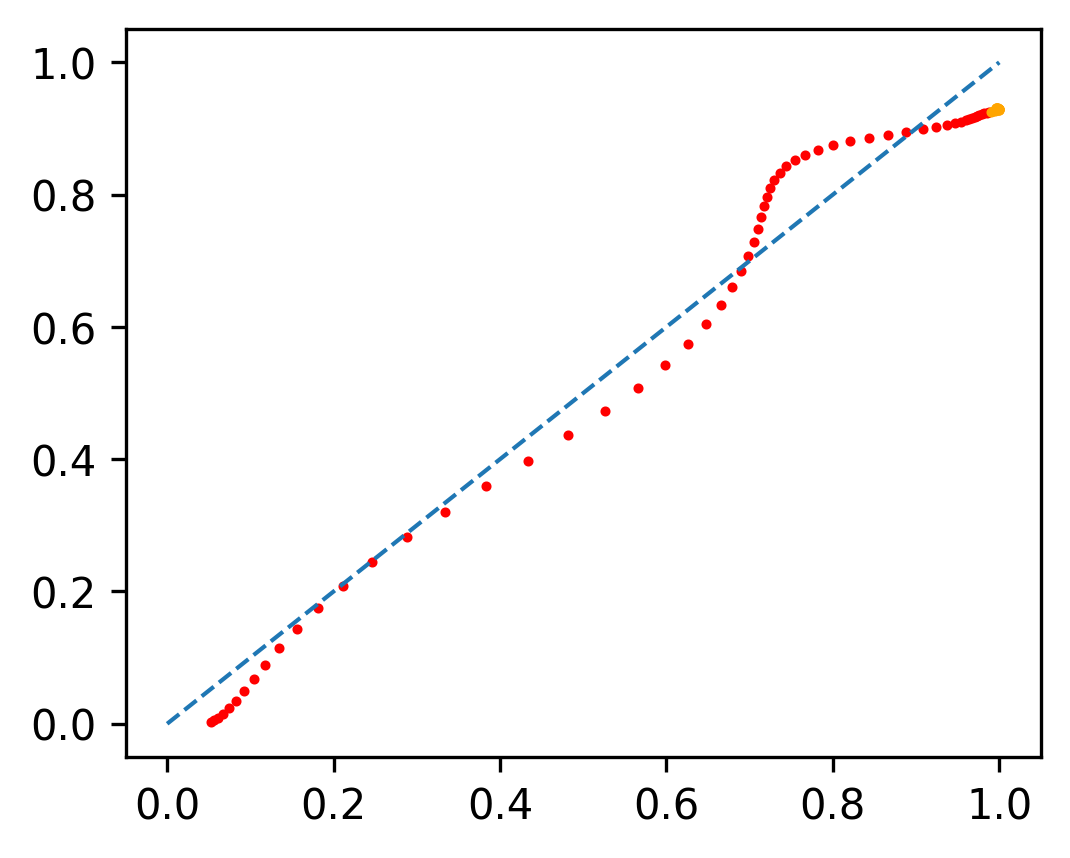

In [15]:
fig=figure(figsize=(width,height), dpi=300)

plt.plot([0,1], [0,1],linestyle='--',linewidth=line_w)
plt.scatter(dn.loc[:train_size-1]['y'],dplot.loc[:train_size-1]['ybms'] , s=marker_s-1, color='red',label='train')
plt.scatter(dn.loc[train_size:]['y'],dplot.loc[train_size:]['ybms'] , s=marker_s-1, color='orange',label='test')

plt.show()